In [1]:
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.svm import *
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.naive_bayes import *
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.discriminant_analysis import *
from sklearn.ensemble import *
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
import re

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df=pd.read_csv('data.csv')

In [3]:
y = df['Bankrupt?']
df=df.drop(columns=['Bankrupt?',' Net Income Flag'])
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### Training and test set prep

In [4]:
random_state = 50

In [5]:
#Simple 80-20
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, stratify = y, random_state = random_state)
X_train.shape, y_train.value_counts()
X_test.shape, y_test.value_counts()

((5455, 94),
 0    5279
 1     176
 Name: Bankrupt?, dtype: int64)

((1364, 94),
 0    1320
 1      44
 Name: Bankrupt?, dtype: int64)

In [6]:
#SMOTE
oversample=SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
X_train_smote.shape
y_train_smote.value_counts()

(10558, 94)

1    5279
0    5279
Name: Bankrupt?, dtype: int64

#### Modeling functions

In [7]:
cols=['FN', 'FP', 'TP', 'TN', 'FPR', 'TPR', 'ACC', 'PREC', 'F1', 'F1 micro', 'F1 macro', 'F1 weighted']
results = pd.DataFrame(columns=cols)

In [8]:

kf = StratifiedKFold(n_splits= 3, shuffle=True, random_state = random_state)

def score(model, train=X_train, y=y_train):
    f1=cross_val_score(model, train, y, n_jobs=-1, scoring='f1', cv=kf)
    return print('mean CV f1:', f1.mean())

plt.rcParams.update({'font.size': 14,
                     'figure.figsize':(16, 4)})

def output(model, name='', x=X_test, y=y_test):
    y_pred=model.predict(x)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    plot_confusion_matrix(model, x, y,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')

    plot_roc_curve(model, x, y, ax=ax2)
    ax2.set_title('ROC curve')

    plot_precision_recall_curve(model, x, y, ax=ax3)
    ax3.set_title('Precision-Recall')

    plt.show()  
        
    print(classification_report(y, y_pred))
    
    if name!='':
        fn = np.sum((y_pred==0) & (y_test==1))
        fp = np.sum((y_pred==1) & (y_test==0))
        tp = np.sum((y_pred==1) & (y_test==1))
        tn = np.sum((y_pred==0) & (y_test==0))
    
        fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1.0)
        acc = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)    
    
        f1_binary= f1_score(y, y_pred, average='binary')
        f1_micro= f1_score(y, y_pred, average='micro')
        f1_macro= f1_score(y, y_pred, average='macro')
        f1_weighted= f1_score(y, y_pred, average='weighted')
        global results
        scores=[fn, fp, tp, tn, fpr[1], tpr[1], acc, precision, f1_binary, f1_micro, f1_macro, f1_weighted]
        scores_series = pd.Series(scores, index=results.columns, name=name)
        results=results.append(scores_series, ignore_index=False)

    return

In [9]:
def test(model, models=''):
    model.fit(X_train, y_train)
    score(model, train=X_train, y=y_train)
    
    if models != '':
        output(model, name=(models), x=X_test, y=y_test)
    else:
        output(model, x=X_test, y=y_test)
    return

def smote(model, models=''):
    model.fit(X_train_smote, y_train_smote)
    score(model, train=X_train_smote, y=y_train_smote)
    
    if models != '':
        output(model, name=(models + ' SMOTE'), x=X_test, y=y_test)
    else:
        output(model, x=X_test, y=y_test)
    return

### Random Forest

mean CV f1: 0.16187729231207493


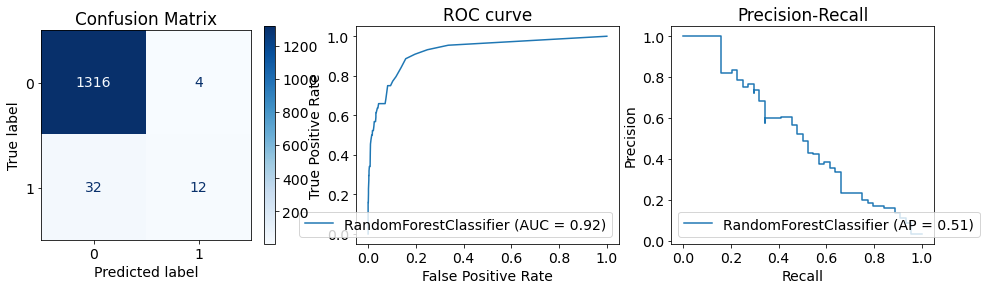

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1320
           1       0.75      0.27      0.40        44

    accuracy                           0.97      1364
   macro avg       0.86      0.63      0.69      1364
weighted avg       0.97      0.97      0.97      1364

mean CV f1: 0.9779332110963038


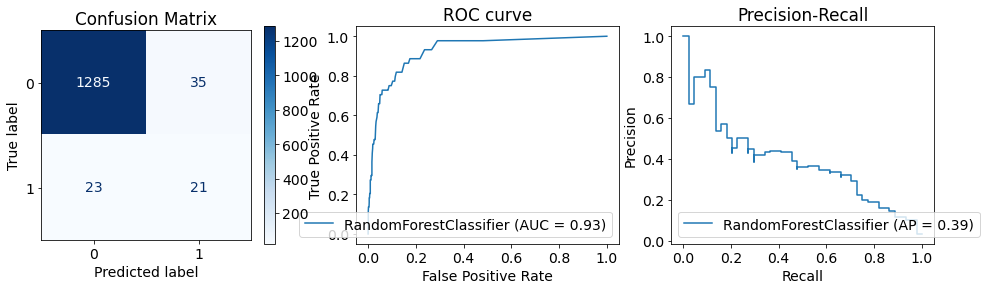

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.38      0.48      0.42        44

    accuracy                           0.96      1364
   macro avg       0.68      0.73      0.70      1364
weighted avg       0.96      0.96      0.96      1364



In [10]:
rfc = RandomForestClassifier()
test(rfc)
smote(rfc)

In [26]:
classweights=['balanced', 'balanced_subsample']
for i in np.arange(1, 50):
        classweights.append({0:1, 1:i})

def objective(trial):    
    max_depth = trial.suggest_int('max_depth', 2, 20)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split= trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 100)
    max_features= trial.suggest_int('max_features', 5, 93)
    

    class_weight= trial.suggest_categorical('class_weight', classweights)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   max_features = max_features,
                                   class_weight = class_weight
                                  )
                           
    model.fit(X_train, y_train)
    f1=cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-23 11:53:01,620] A new study created in memory with name: no-name-be335971-fbdd-4b8a-84bd-c04a271dfa23
[I 2021-07-23 11:53:04,319] Trial 0 finished with value: 0.384592724537129 and parameters: {'max_depth': 12, 'n_estimators': 88, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 42, 'max_features': 7, 'class_weight': {0: 1, 1: 19}}. Best is trial 0 with value: 0.384592724537129.
[I 2021-07-23 11:53:10,534] Trial 1 finished with value: 0.35668511293056526 and parameters: {'max_depth': 19, 'n_estimators': 126, 'criterion': 'gini', 'min_samples_split': 21, 'min_samples_leaf': 43, 'max_features': 23, 'class_weight': {0: 1, 1: 46}}. Best is trial 0 with value: 0.384592724537129.
[I 2021-07-23 11:53:30,423] Trial 2 finished with value: 0.34810790952471116 and parameters: {'max_depth': 16, 'n_estimators': 103, 'criterion': 'entropy', 'min_samples_split': 23, 'min_samples_leaf': 74, 'max_features': 91, 'class_weight': {0: 1, 1: 34}}. Best is trial 0 with value: 0.3

[I 2021-07-23 11:58:59,014] Trial 26 finished with value: 0.426310807401601 and parameters: {'max_depth': 13, 'n_estimators': 151, 'criterion': 'entropy', 'min_samples_split': 43, 'min_samples_leaf': 53, 'max_features': 78, 'class_weight': {0: 1, 1: 11}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 11:59:29,819] Trial 27 finished with value: 0.4200138930465318 and parameters: {'max_depth': 17, 'n_estimators': 184, 'criterion': 'gini', 'min_samples_split': 53, 'min_samples_leaf': 14, 'max_features': 74, 'class_weight': {0: 1, 1: 27}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:00:02,405] Trial 28 finished with value: 0.4289521816512538 and parameters: {'max_depth': 11, 'n_estimators': 140, 'criterion': 'entropy', 'min_samples_split': 73, 'min_samples_leaf': 36, 'max_features': 92, 'class_weight': {0: 1, 1: 5}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:00:23,180] Trial 29 finished with value: 0.36719261273029163 and paramete

[I 2021-07-23 12:08:25,401] Trial 52 finished with value: 0.3645883453297219 and parameters: {'max_depth': 7, 'n_estimators': 147, 'criterion': 'entropy', 'min_samples_split': 91, 'min_samples_leaf': 65, 'max_features': 82, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:09:00,087] Trial 53 finished with value: 0.36864668272884815 and parameters: {'max_depth': 13, 'n_estimators': 170, 'criterion': 'entropy', 'min_samples_split': 97, 'min_samples_leaf': 61, 'max_features': 90, 'class_weight': 'balanced_subsample'}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:09:19,593] Trial 54 finished with value: 0.33294816767246593 and parameters: {'max_depth': 10, 'n_estimators': 121, 'criterion': 'entropy', 'min_samples_split': 81, 'min_samples_leaf': 69, 'max_features': 80, 'class_weight': {0: 1, 1: 42}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:09:27,568] Trial 55 finished with value: 0.4104775230126777 and

[I 2021-07-23 12:16:13,603] Trial 78 finished with value: 0.41905224164259225 and parameters: {'max_depth': 11, 'n_estimators': 142, 'criterion': 'entropy', 'min_samples_split': 19, 'min_samples_leaf': 37, 'max_features': 73, 'class_weight': {0: 1, 1: 13}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:16:30,234] Trial 79 finished with value: 0.3714959431481171 and parameters: {'max_depth': 12, 'n_estimators': 106, 'criterion': 'gini', 'min_samples_split': 43, 'min_samples_leaf': 59, 'max_features': 84, 'class_weight': {0: 1, 1: 25}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:16:47,581] Trial 80 finished with value: 0.4241257146576688 and parameters: {'max_depth': 8, 'n_estimators': 164, 'criterion': 'entropy', 'min_samples_split': 98, 'min_samples_leaf': 54, 'max_features': 45, 'class_weight': {0: 1, 1: 10}}. Best is trial 5 with value: 0.4497846889952153.
[I 2021-07-23 12:17:23,413] Trial 81 finished with value: 0.4382531849367659 and paramet

In [9]:
params={'max_depth': 10, 
        'n_estimators': 191, 
        'criterion': 'entropy', 
        'min_samples_split': 51, 
        'min_samples_leaf': 8, 
        'max_features': 78, 
        'class_weight': {0: 1, 1: 7}}

mean CV f1: 0.45979945979945985


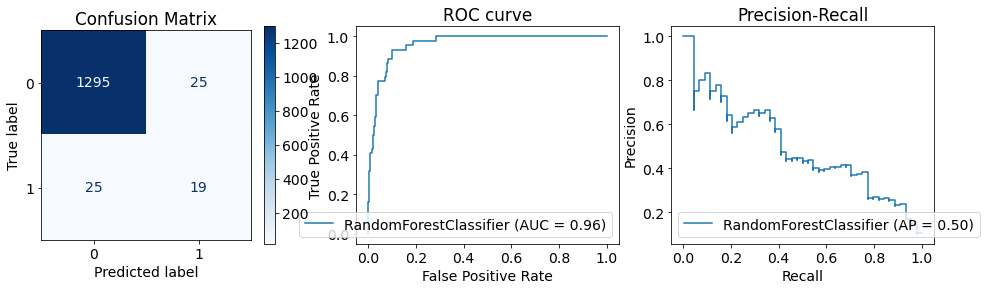

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.43      0.43      0.43        44

    accuracy                           0.96      1364
   macro avg       0.71      0.71      0.71      1364
weighted avg       0.96      0.96      0.96      1364



In [10]:
rfc_r = RandomForestClassifier(**params)
test(rfc_r, 'Random Forest')

mean CV f1: 0.9437451574606402


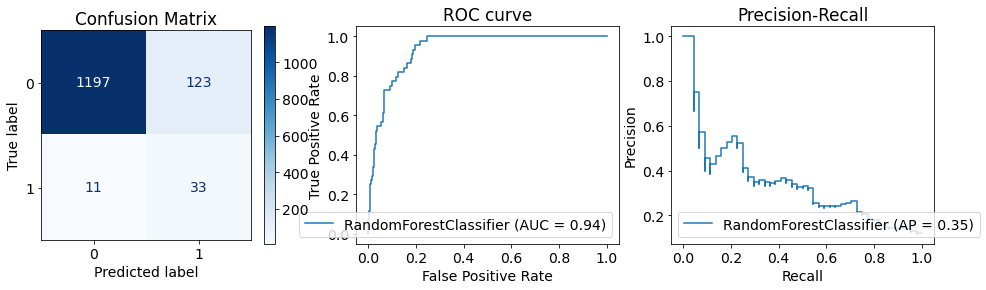

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1320
           1       0.21      0.75      0.33        44

    accuracy                           0.90      1364
   macro avg       0.60      0.83      0.64      1364
weighted avg       0.97      0.90      0.93      1364



In [11]:
smote(rfc_r)

In [42]:
def objective(trial):    
    max_depth = trial.suggest_int('max_depth', 2, 20)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split= trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 100)
    max_features= trial.suggest_int('max_features', 5, 93)
    

    class_weight= trial.suggest_categorical('class_weight', classweights)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   max_features = max_features,
                                   class_weight = class_weight
                                  )
                           
    model.fit(X_train_smote, y_train_smote)
    f1=cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-23 12:50:29,214] A new study created in memory with name: no-name-fdd331b6-3e93-46e3-9772-2365c770f214
[I 2021-07-23 12:50:44,291] Trial 0 finished with value: 0.8554830325221949 and parameters: {'max_depth': 11, 'n_estimators': 161, 'criterion': 'entropy', 'min_samples_split': 99, 'min_samples_leaf': 79, 'max_features': 10, 'class_weight': {0: 1, 1: 48}}. Best is trial 0 with value: 0.8554830325221949.
[I 2021-07-23 12:51:12,116] Trial 1 finished with value: 0.9329760110176034 and parameters: {'max_depth': 15, 'n_estimators': 72, 'criterion': 'entropy', 'min_samples_split': 40, 'min_samples_leaf': 26, 'max_features': 37, 'class_weight': {0: 1, 1: 23}}. Best is trial 1 with value: 0.9329760110176034.
[I 2021-07-23 12:53:03,937] Trial 2 finished with value: 0.9227375404680936 and parameters: {'max_depth': 13, 'n_estimators': 168, 'criterion': 'gini', 'min_samples_split': 73, 'min_samples_leaf': 57, 'max_features': 87, 'class_weight': {0: 1, 1: 5}}. Best is trial 1 with value:

[I 2021-07-23 13:13:09,828] Trial 26 finished with value: 0.9382856174666555 and parameters: {'max_depth': 14, 'n_estimators': 59, 'criterion': 'entropy', 'min_samples_split': 22, 'min_samples_leaf': 18, 'max_features': 32, 'class_weight': {0: 1, 1: 45}}. Best is trial 16 with value: 0.9784112307879432.
[I 2021-07-23 13:13:53,775] Trial 27 finished with value: 0.8690320443438637 and parameters: {'max_depth': 17, 'n_estimators': 134, 'criterion': 'entropy', 'min_samples_split': 47, 'min_samples_leaf': 98, 'max_features': 44, 'class_weight': {0: 1, 1: 47}}. Best is trial 16 with value: 0.9784112307879432.
[I 2021-07-23 13:14:16,273] Trial 28 finished with value: 0.9770065519038275 and parameters: {'max_depth': 19, 'n_estimators': 40, 'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 51, 'class_weight': {0: 1, 1: 1}}. Best is trial 16 with value: 0.9784112307879432.
[I 2021-07-23 13:14:29,582] Trial 29 finished with value: 0.8856943045394136 and parame

[I 2021-07-23 13:31:37,532] Trial 52 finished with value: 0.978791593652453 and parameters: {'max_depth': 19, 'n_estimators': 198, 'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 58, 'class_weight': {0: 1, 1: 1}}. Best is trial 49 with value: 0.9796832653686165.
[I 2021-07-23 13:33:28,142] Trial 53 finished with value: 0.9686952236588423 and parameters: {'max_depth': 19, 'n_estimators': 200, 'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 58, 'class_weight': {0: 1, 1: 1}}. Best is trial 49 with value: 0.9796832653686165.
[I 2021-07-23 13:35:58,291] Trial 54 finished with value: 0.9745450371241166 and parameters: {'max_depth': 20, 'n_estimators': 179, 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 77, 'class_weight': {0: 1, 1: 1}}. Best is trial 49 with value: 0.9796832653686165.
[I 2021-07-23 13:38:27,034] Trial 55 finished with value: 0.9701977984460669 and parameters

[I 2021-07-23 14:15:28,083] Trial 78 finished with value: 0.9645144511079554 and parameters: {'max_depth': 18, 'n_estimators': 166, 'criterion': 'entropy', 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 5, 'class_weight': 'balanced_subsample'}. Best is trial 65 with value: 0.9800702101270591.
[I 2021-07-23 14:16:23,934] Trial 79 finished with value: 0.9721170959026366 and parameters: {'max_depth': 20, 'n_estimators': 78, 'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 68, 'class_weight': 'balanced'}. Best is trial 65 with value: 0.9800702101270591.
[I 2021-07-23 14:17:29,516] Trial 80 finished with value: 0.9609452615131311 and parameters: {'max_depth': 17, 'n_estimators': 89, 'criterion': 'entropy', 'min_samples_split': 57, 'min_samples_leaf': 1, 'max_features': 54, 'class_weight': {0: 1, 1: 26}}. Best is trial 65 with value: 0.9800702101270591.
[I 2021-07-23 14:19:55,779] Trial 81 finished with value: 0.9774040849198024 and para

In [17]:
params = {'max_depth': 19, 
          'n_estimators': 187, 
          'criterion': 'entropy', 
          'min_samples_split': 2, 
          'min_samples_leaf': 1, 
          'max_features': 5, 
          'class_weight': {0: 1, 1: 7}}

mean CV f1: 0.9778951103884138


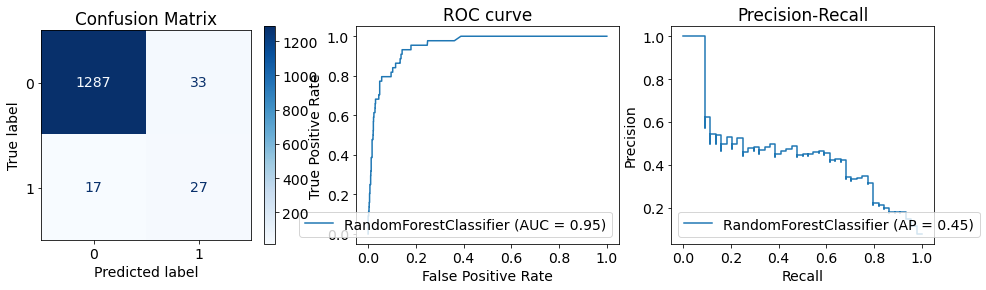

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.45      0.61      0.52        44

    accuracy                           0.96      1364
   macro avg       0.72      0.79      0.75      1364
weighted avg       0.97      0.96      0.97      1364



In [18]:
rfc_r = RandomForestClassifier(**params)
smote(rfc_r, 'RF smote')

## GradientBoostingClassifier

mean CV f1: 0.3624824617040497


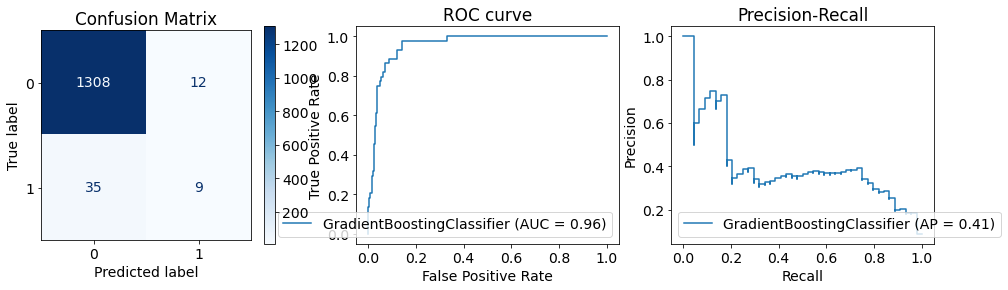

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1320
           1       0.43      0.20      0.28        44

    accuracy                           0.97      1364
   macro avg       0.70      0.60      0.63      1364
weighted avg       0.96      0.97      0.96      1364

mean CV f1: 0.9651056154484475


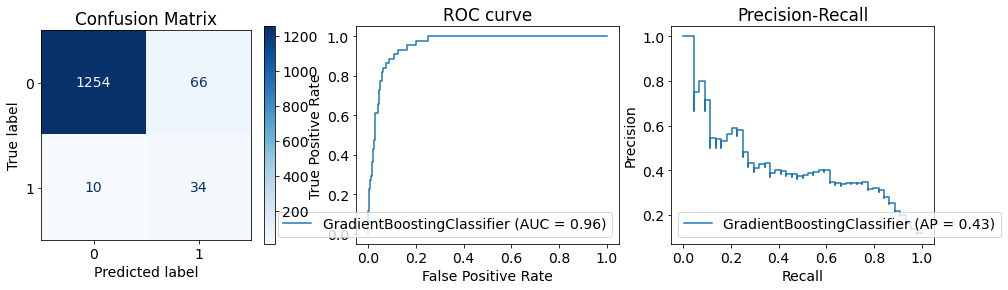

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.34      0.77      0.47        44

    accuracy                           0.94      1364
   macro avg       0.67      0.86      0.72      1364
weighted avg       0.97      0.94      0.95      1364



In [19]:
gbc = GradientBoostingClassifier()
test(gbc)
smote(gbc)

In [24]:
def objective(trial):
    
    loss = trial.suggest_categorical('loss', ['deviance', 'exponential'])
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    min_samples_split = trial.suggest_loguniform('min_samples_split', 0.001, 1)
    min_samples_leaf = trial.suggest_loguniform('min_samples_leaf', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_int('max_features', 1, 94)
    
    model = GradientBoostingClassifier(loss=loss,
                                       n_estimators=n_estimators,
                                       subsample=subsample, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       max_features=max_features)
    
    model.fit(X_train, y_train)
    f1=cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-07-24 10:28:19,053] A new study created in memory with name: no-name-b7445b4a-0194-4b03-a2bd-4a35eb479926
[I 2021-07-24 10:28:47,391] Trial 0 finished with value: 0.28829471182412364 and parameters: {'loss': 'exponential', 'n_estimators': 471, 'subsample': 0.43233613142687966, 'min_samples_split': 0.06757584971031005, 'min_samples_leaf': 0.02596513369657577, 'max_depth': 11, 'max_features': 34}. Best is trial 0 with value: 0.28829471182412364.
[I 2021-07-24 10:28:48,764] Trial 1 finished with value: 0.07427194466128893 and parameters: {'loss': 'exponential', 'n_estimators': 45, 'subsample': 0.7810962274762437, 'min_samples_split': 0.07110167694525596, 'min_samples_leaf': 0.0460485702893036, 'max_depth': 10, 'max_features': 9}. Best is trial 0 with value: 0.28829471182412364.
[I 2021-07-24 10:28:49,936] Trial 2 finished with value: 0.062049062049062055 and parameters: {'loss': 'deviance', 'n_estimators': 275, 'subsample': 0.06083502926332706, 'min_samples_split': 0.0303302969646

[I 2021-07-24 10:38:43,758] Trial 23 finished with value: 0.34317523335967265 and parameters: {'loss': 'exponential', 'n_estimators': 64, 'subsample': 0.28289933347189944, 'min_samples_split': 0.004978247872934134, 'min_samples_leaf': 0.0048609706875974565, 'max_depth': 16, 'max_features': 13}. Best is trial 17 with value: 0.41770110648019904.
[I 2021-07-24 10:38:57,864] Trial 24 finished with value: 0.40052384590199724 and parameters: {'loss': 'exponential', 'n_estimators': 133, 'subsample': 0.3956380014031038, 'min_samples_split': 0.01645503053749953, 'min_samples_leaf': 0.007121438289666774, 'max_depth': 13, 'max_features': 40}. Best is trial 17 with value: 0.41770110648019904.
[I 2021-07-24 10:39:22,849] Trial 25 finished with value: 0.345204623555139 and parameters: {'loss': 'exponential', 'n_estimators': 181, 'subsample': 0.4365074140729862, 'min_samples_split': 0.017154334353988904, 'min_samples_leaf': 0.013044188706290016, 'max_depth': 12, 'max_features': 56}. Best is trial 17 

[I 2021-07-24 10:42:09,563] Trial 47 finished with value: 0.35385772619815176 and parameters: {'loss': 'exponential', 'n_estimators': 46, 'subsample': 0.11112591802428641, 'min_samples_split': 0.023768965168860925, 'min_samples_leaf': 0.0015196666680720272, 'max_depth': 14, 'max_features': 16}. Best is trial 37 with value: 0.41915634810954416.
[I 2021-07-24 10:42:09,832] Trial 48 finished with value: 0.0 and parameters: {'loss': 'deviance', 'n_estimators': 90, 'subsample': 0.03798629709785356, 'min_samples_split': 0.07535425355705094, 'min_samples_leaf': 0.001336579548062972, 'max_depth': 12, 'max_features': 3}. Best is trial 37 with value: 0.41915634810954416.
[I 2021-07-24 10:42:10,477] Trial 49 finished with value: 0.4364411142879052 and parameters: {'loss': 'exponential', 'n_estimators': 151, 'subsample': 0.05475007454483049, 'min_samples_split': 0.035007989410884614, 'min_samples_leaf': 0.004477768163814546, 'max_depth': 16, 'max_features': 18}. Best is trial 49 with value: 0.4364

In [25]:
params ={'loss': 'exponential', 
         'n_estimators': 151, 
         'subsample': 0.05475007454483049, 
         'min_samples_split': 0.035007989410884614, 
         'min_samples_leaf': 0.004477768163814546, 
         'max_depth': 16, 
         'max_features': 18}

mean CV f1: 0.41877116594097724


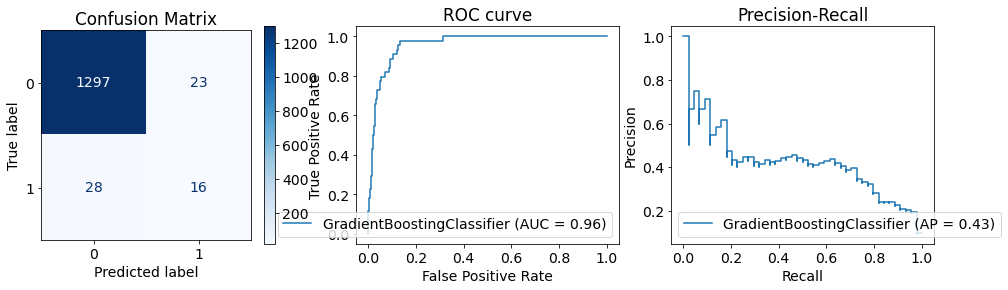

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.41      0.36      0.39        44

    accuracy                           0.96      1364
   macro avg       0.69      0.67      0.68      1364
weighted avg       0.96      0.96      0.96      1364



In [29]:
gbc =GradientBoostingClassifier(**params)
test(gbc, 'GradientBoost')

In [38]:
def objective(trial):
    
    loss = trial.suggest_categorical('loss', ['deviance', 'exponential'])
    n_estimators = trial.suggest_int('n_estimators', 1, 300)
    subsample = trial.suggest_float('subsample', 0.001, 1)
    min_samples_split = trial.suggest_loguniform('min_samples_split', 0.001, 1)
    min_samples_leaf = trial.suggest_loguniform('min_samples_leaf', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    max_features = trial.suggest_int('max_features', 1, 94)
    
    model = GradientBoostingClassifier(loss=loss,
                                       n_estimators=n_estimators,
                                       subsample=subsample, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_depth=max_depth,
                                       max_features=max_features)
    
    f1=cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-07-24 15:14:04,622] A new study created in memory with name: no-name-1da5ac68-99d0-4850-bdfc-b1800059f72f
[I 2021-07-24 15:14:49,069] Trial 0 finished with value: 0.3953488372093023 and parameters: {'loss': 'deviance', 'n_estimators': 208, 'subsample': 0.44930346516488306, 'min_samples_split': 0.0870094656639472, 'min_samples_leaf': 0.002945678722323502, 'max_depth': 26, 'max_features': 75}. Best is trial 0 with value: 0.3953488372093023.
[I 2021-07-24 15:14:49,278] Trial 1 finished with value: 0.0625 and parameters: {'loss': 'exponential', 'n_estimators': 139, 'subsample': 0.3195998711203758, 'min_samples_split': 0.006803600106972004, 'min_samples_leaf': 0.1638072359065047, 'max_depth': 15, 'max_features': 68}. Best is trial 0 with value: 0.3953488372093023.
[I 2021-07-24 15:15:05,004] Trial 2 finished with value: 0.4755244755244755 and parameters: {'loss': 'exponential', 'n_estimators': 153, 'subsample': 0.8228491220032867, 'min_samples_split': 0.18484242307645402, 'min_sampl

[I 2021-07-24 15:22:42,731] Trial 24 finished with value: 0.46341463414634143 and parameters: {'loss': 'exponential', 'n_estimators': 217, 'subsample': 0.72328380833572, 'min_samples_split': 0.015755545195559655, 'min_samples_leaf': 0.0010838842888276053, 'max_depth': 9, 'max_features': 56}. Best is trial 14 with value: 0.5252525252525252.
[I 2021-07-24 15:22:59,814] Trial 25 finished with value: 0.45098039215686275 and parameters: {'loss': 'exponential', 'n_estimators': 246, 'subsample': 0.5582126233830271, 'min_samples_split': 0.047215579792887555, 'min_samples_leaf': 0.004471529982198662, 'max_depth': 4, 'max_features': 39}. Best is trial 14 with value: 0.5252525252525252.
[I 2021-07-24 15:24:14,161] Trial 26 finished with value: 0.4482758620689656 and parameters: {'loss': 'exponential', 'n_estimators': 265, 'subsample': 0.9596582364038826, 'min_samples_split': 0.36810204412807246, 'min_samples_leaf': 0.015509202290668291, 'max_depth': 11, 'max_features': 94}. Best is trial 14 with 

[I 2021-07-24 15:35:49,217] Trial 48 finished with value: 0.36018957345971564 and parameters: {'loss': 'exponential', 'n_estimators': 9, 'subsample': 0.8016131142117716, 'min_samples_split': 0.10663501714176522, 'min_samples_leaf': 0.01702695611694929, 'max_depth': 11, 'max_features': 32}. Best is trial 47 with value: 0.5274725274725275.
[I 2021-07-24 15:36:12,663] Trial 49 finished with value: 0.49586776859504134 and parameters: {'loss': 'exponential', 'n_estimators': 233, 'subsample': 0.8641414586394276, 'min_samples_split': 0.018448068547846082, 'min_samples_leaf': 0.11686629508041112, 'max_depth': 9, 'max_features': 50}. Best is trial 47 with value: 0.5274725274725275.


In [48]:
params =  {'loss': 'exponential', 
           'n_estimators': 260, 
           'subsample': 0.9154430326999043, 
           'min_samples_split': 0.09827008944795469, 
           'min_samples_leaf': 0.02278337420890365, 
           'max_depth': 7, 
           'max_features': 44}

mean CV f1: 0.9844720166529953


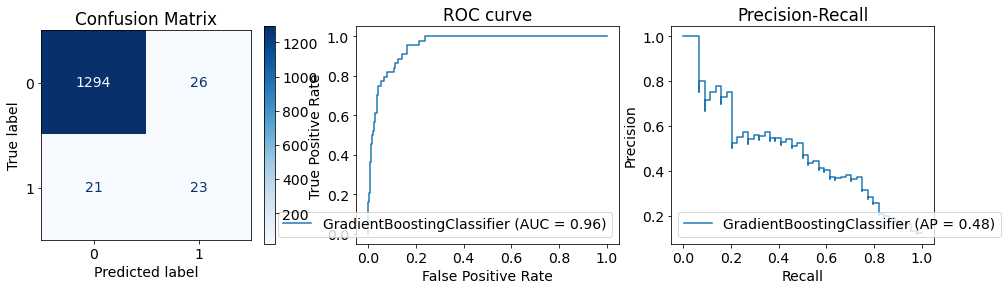

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.47      0.52      0.49        44

    accuracy                           0.97      1364
   macro avg       0.73      0.75      0.74      1364
weighted avg       0.97      0.97      0.97      1364



In [49]:
gbc =GradientBoostingClassifier(**params)
smote(gbc, 'GB smote')

## LightGBM

mean CV f1: 0.3056416726748378


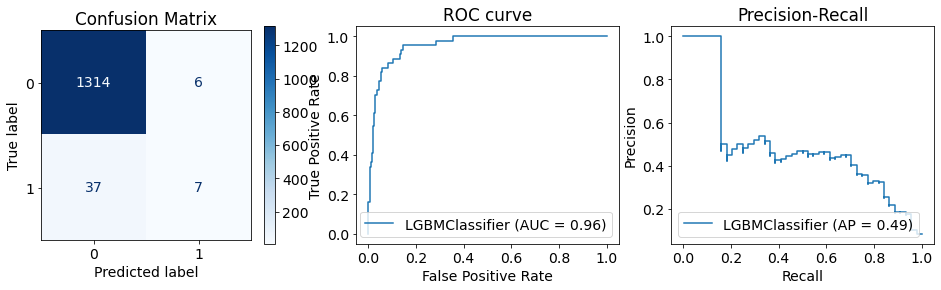

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.54      0.16      0.25        44

    accuracy                           0.97      1364
   macro avg       0.76      0.58      0.61      1364
weighted avg       0.96      0.97      0.96      1364

mean CV f1: 0.9850339386691006


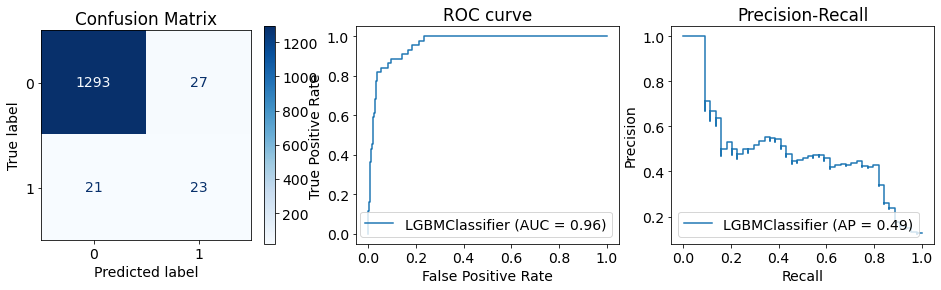

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.46      0.52      0.49        44

    accuracy                           0.96      1364
   macro avg       0.72      0.75      0.74      1364
weighted avg       0.97      0.96      0.97      1364



In [41]:
lgbm = LGBMClassifier()
test(lgbm)
smote(lgbm)

In [74]:
def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    num_leaves = trial.suggest_int('num_leaves',2,70),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.2),
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    subsample_for_bin = trial.suggest_int('subsample_for_bin', 50000, 400000)
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    
    model = LGBMClassifier(boosting_type = boosting_type,
                           num_leaves = num_leaves,
                           max_depth = max_depth,
                           learning_rate = learning_rate,
                           n_estimators = n_estimators,
                           subsample_for_bin = subsample_for_bin,
                           objective = 'binary',
                           lambda_l1 = lambda_l1,
                           lambda_l2 = lambda_l2,
                           bagging_fraction = bagging_fraction,
                           feature_fraction = feature_fraction,
                           bagging_freq = bagging_freq,
                           min_data_in_leaf = min_data_in_leaf,
                           min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
                           num_threads = num_threads,
                           scale_pos_weight = scale_pos_weight)
                           
    model.fit(X_train, y_train)
    f1=cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-23 22:02:19,665] A new study created in memory with name: no-name-0e15850c-dcbb-49c8-81ae-790ae73168c8
[I 2021-07-23 22:02:20,597] Trial 0 finished with value: 0.4485688875464605 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 13, 'learning_rate': 0.12184945772204231, 'n_estimators': 154, 'subsample_for_bin': 124262, 'bagging_freq': 10, 'min_data_in_leaf': 37, 'lambda_l1': 0.28088582037014304, 'lambda_l2': 1.665064531335777, 'bagging_fraction': 0.4710781912849501, 'feature_fraction': 0.41251260970924564, 'num_threads': 10, 'min_sum_hessian_in_leaf': 9, 'scale_pos_weight': 59}. Best is trial 0 with value: 0.4485688875464605.
[I 2021-07-23 22:02:20,909] Trial 1 finished with value: 0.11540301846493765 and parameters: {'boosting_type': 'rf', 'num_leaves': 13, 'max_depth': 1, 'learning_rate': 0.016010051409393745, 'n_estimators': 49, 'subsample_for_bin': 358127, 'bagging_freq': 3, 'min_data_in_leaf': 48, 'lambda_l1': 1.2679996166167296e-08, 'lambda_l2': 

[I 2021-07-23 22:02:33,139] Trial 15 finished with value: 0.3199273911861694 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'max_depth': 11, 'learning_rate': 0.03497239498178153, 'n_estimators': 94, 'subsample_for_bin': 97581, 'bagging_freq': 8, 'min_data_in_leaf': 38, 'lambda_l1': 0.011077844854185837, 'lambda_l2': 0.010083927144496416, 'bagging_fraction': 0.9974199217015514, 'feature_fraction': 0.5183136350046831, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8, 'scale_pos_weight': 51}. Best is trial 12 with value: 0.47761215327882.
[I 2021-07-23 22:02:34,373] Trial 16 finished with value: 0.48253017842767615 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'max_depth': 16, 'learning_rate': 0.11545482474209964, 'n_estimators': 113, 'subsample_for_bin': 257844, 'bagging_freq': 9, 'min_data_in_leaf': 15, 'lambda_l1': 4.891096717323201e-05, 'lambda_l2': 0.3266405908512727, 'bagging_fraction': 0.6881944367247624, 'feature_fraction': 0.11164497854233651, 'num_threads

[I 2021-07-23 22:02:49,829] Trial 30 finished with value: 0.4207789835442803 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 11, 'learning_rate': 0.146427461540629, 'n_estimators': 88, 'subsample_for_bin': 281027, 'bagging_freq': 5, 'min_data_in_leaf': 40, 'lambda_l1': 8.818079097765126e-05, 'lambda_l2': 0.3863811701284163, 'bagging_fraction': 0.7335149433960706, 'feature_fraction': 0.10945984185720808, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5, 'scale_pos_weight': 31}. Best is trial 28 with value: 0.48963562397271343.
[I 2021-07-23 22:02:51,203] Trial 31 finished with value: 0.4831501831501831 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 14, 'learning_rate': 0.09353471463385624, 'n_estimators': 108, 'subsample_for_bin': 378542, 'bagging_freq': 5, 'min_data_in_leaf': 11, 'lambda_l1': 1.1424232268228864e-06, 'lambda_l2': 0.0013269285918231434, 'bagging_fraction': 0.877364200144101, 'feature_fraction': 0.26273924149110434, 'num_thr

[I 2021-07-23 22:03:06,977] Trial 45 finished with value: 0.4749930448660032 and parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'max_depth': 16, 'learning_rate': 0.04440748222458893, 'n_estimators': 136, 'subsample_for_bin': 299813, 'bagging_freq': 4, 'min_data_in_leaf': 26, 'lambda_l1': 8.250162598365e-06, 'lambda_l2': 0.005578169411095994, 'bagging_fraction': 0.898413547297642, 'feature_fraction': 0.4149845486656841, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4, 'scale_pos_weight': 41}. Best is trial 28 with value: 0.48963562397271343.
[I 2021-07-23 22:03:07,735] Trial 46 finished with value: 0.41768497776872693 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': 13, 'learning_rate': 0.162560744958546, 'n_estimators': 70, 'subsample_for_bin': 240698, 'bagging_freq': 3, 'min_data_in_leaf': 35, 'lambda_l1': 1.7868501019079051e-06, 'lambda_l2': 5.655282002821606e-06, 'bagging_fraction': 0.5608382230524299, 'feature_fraction': 0.5698177780399794, 'num_thre

[I 2021-07-23 22:03:39,146] Trial 60 finished with value: 0.4651012796664828 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 17, 'learning_rate': 0.02867784384334759, 'n_estimators': 63, 'subsample_for_bin': 227605, 'bagging_freq': 6, 'min_data_in_leaf': 22, 'lambda_l1': 6.224352440834469e-08, 'lambda_l2': 6.821038803014505e-08, 'bagging_fraction': 0.848994116416661, 'feature_fraction': 0.5159872630408024, 'num_threads': 9, 'min_sum_hessian_in_leaf': 8, 'scale_pos_weight': 22}. Best is trial 51 with value: 0.5061785143454809.
[I 2021-07-23 22:03:41,919] Trial 61 finished with value: 0.4674752382120803 and parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': 19, 'learning_rate': 0.046939635389290794, 'n_estimators': 117, 'subsample_for_bin': 178483, 'bagging_freq': 6, 'min_data_in_leaf': 17, 'lambda_l1': 3.678800360898336e-08, 'lambda_l2': 4.150793419301139e-08, 'bagging_fraction': 0.7783121017928154, 'feature_fraction': 0.7562107854848779, 'num_

[I 2021-07-23 22:04:16,434] Trial 75 finished with value: 0.47054832787932 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.07343592551184563, 'n_estimators': 77, 'subsample_for_bin': 119996, 'bagging_freq': 7, 'min_data_in_leaf': 2, 'lambda_l1': 1.443233281555793e-08, 'lambda_l2': 2.3258961588918504e-07, 'bagging_fraction': 0.6300461893463832, 'feature_fraction': 0.7037344090559178, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4, 'scale_pos_weight': 8}. Best is trial 51 with value: 0.5061785143454809.
[I 2021-07-23 22:04:19,485] Trial 76 finished with value: 0.4618431642486499 and parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'max_depth': 19, 'learning_rate': 0.03268969407300538, 'n_estimators': 102, 'subsample_for_bin': 137648, 'bagging_freq': 7, 'min_data_in_leaf': 12, 'lambda_l1': 8.078010866263923e-08, 'lambda_l2': 8.778802901093497e-07, 'bagging_fraction': 0.6817230392868381, 'feature_fraction': 0.8597991967896214, 'num_thr

[I 2021-07-23 22:04:41,589] Trial 90 finished with value: 0.48433740471970516 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'max_depth': 19, 'learning_rate': 0.040372477142581374, 'n_estimators': 68, 'subsample_for_bin': 225551, 'bagging_freq': 5, 'min_data_in_leaf': 12, 'lambda_l1': 2.497249841189039e-08, 'lambda_l2': 0.0026744723716648016, 'bagging_fraction': 0.833927318895104, 'feature_fraction': 0.6300647800176326, 'num_threads': 9, 'min_sum_hessian_in_leaf': 5, 'scale_pos_weight': 9}. Best is trial 51 with value: 0.5061785143454809.
[I 2021-07-23 22:04:44,196] Trial 91 finished with value: 0.46935199849834 and parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': 17, 'learning_rate': 0.0569841924361437, 'n_estimators': 93, 'subsample_for_bin': 186719, 'bagging_freq': 6, 'min_data_in_leaf': 5, 'lambda_l1': 1.003407659748441e-08, 'lambda_l2': 1.1284972569623973e-08, 'bagging_fraction': 0.743012096738785, 'feature_fraction': 0.7099634194088424, 'num_threa

In [44]:
params = {'boosting_type': 'rf', 
          'num_leaves': 47, 
          'max_depth': 5, 
          'learning_rate': 0.07162554136330458, 
          'n_estimators': 192, 
          'subsample_for_bin': 166307, 
          'bagging_freq': 6, 
          'min_data_in_leaf': 14, 
          'lambda_l1': 0.1654260899402262, 
          'lambda_l2': 0.7263466248471901, 
          'bagging_fraction': 0.49106685394922966, 
          'feature_fraction': 0.6651939867004374, 
          'num_threads': 7, 
          'min_sum_hessian_in_leaf': 1}

mean CV f1: 0.42371955529850264


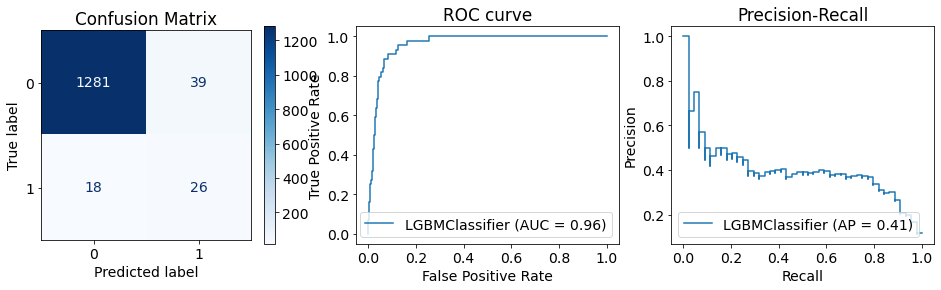

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.40      0.59      0.48        44

    accuracy                           0.96      1364
   macro avg       0.69      0.78      0.73      1364
weighted avg       0.97      0.96      0.96      1364



In [45]:
lgbm = LGBMClassifier(**params)
test(lgbm, 'LGBM')

In [77]:
def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf'])
    num_leaves = trial.suggest_int('num_leaves',2,70),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.2),
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    subsample_for_bin = trial.suggest_int('subsample_for_bin', 50000, 400000)
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    
    model = LGBMClassifier(boosting_type = boosting_type,
                           num_leaves = num_leaves,
                           max_depth = max_depth,
                           learning_rate = learning_rate,
                           n_estimators = n_estimators,
                           subsample_for_bin = subsample_for_bin,
                           objective = 'binary',
                           lambda_l1 = lambda_l1,
                           lambda_l2 = lambda_l2,
                           bagging_fraction = bagging_fraction,
                           feature_fraction = feature_fraction,
                           bagging_freq = bagging_freq,
                           min_data_in_leaf = min_data_in_leaf,
                           min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
                           num_threads = num_threads,
                           scale_pos_weight=scale_pos_weight)
                           
    model.fit(X_train_smote, y_train_smote)
    f1=cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-07-23 22:14:11,829] A new study created in memory with name: no-name-c7256c0f-6ab6-4abf-81af-696c40c21a6f
[I 2021-07-23 22:14:14,223] Trial 0 finished with value: 0.8714043227541154 and parameters: {'boosting_type': 'rf', 'num_leaves': 36, 'max_depth': 10, 'learning_rate': 0.0030729395506323264, 'n_estimators': 112, 'subsample_for_bin': 88597, 'bagging_freq': 2, 'min_data_in_leaf': 29, 'lambda_l1': 1.104831367411299e-07, 'lambda_l2': 0.0034183230257557222, 'bagging_fraction': 0.38210885771550995, 'feature_fraction': 0.3806361655203023, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3, 'scale_pos_weight': 94}. Best is trial 0 with value: 0.8714043227541154.
[I 2021-07-23 22:14:16,136] Trial 1 finished with value: 0.834429191523695 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': 4, 'learning_rate': 0.002354782283026469, 'n_estimators': 96, 'subsample_for_bin': 79163, 'bagging_freq': 8, 'min_data_in_leaf': 83, 'lambda_l1': 0.0019557826575714245, 'lambda_l2':

[I 2021-07-23 22:14:41,845] Trial 15 finished with value: 0.9409396102423878 and parameters: {'boosting_type': 'rf', 'num_leaves': 50, 'max_depth': 16, 'learning_rate': 0.011646675433659293, 'n_estimators': 26, 'subsample_for_bin': 292578, 'bagging_freq': 10, 'min_data_in_leaf': 4, 'lambda_l1': 1.6024753122053957e-06, 'lambda_l2': 5.547713292949831e-06, 'bagging_fraction': 0.862520903847139, 'feature_fraction': 0.541785172403729, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4, 'scale_pos_weight': 18}. Best is trial 13 with value: 0.9586558924946675.
[I 2021-07-23 22:14:43,402] Trial 16 finished with value: 0.942105670052501 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': 17, 'learning_rate': 0.02166358377986228, 'n_estimators': 34, 'subsample_for_bin': 161723, 'bagging_freq': 9, 'min_data_in_leaf': 7, 'lambda_l1': 0.0002161169068096073, 'lambda_l2': 3.168660215992754e-05, 'bagging_fraction': 0.8806231906593555, 'feature_fraction': 0.6355100782093097, 'num_threads

[I 2021-07-23 22:15:17,400] Trial 30 finished with value: 0.968335546201185 and parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 10, 'learning_rate': 0.11685676886205779, 'n_estimators': 108, 'subsample_for_bin': 370131, 'bagging_freq': 5, 'min_data_in_leaf': 10, 'lambda_l1': 5.028863647958441e-06, 'lambda_l2': 5.636519204768302e-05, 'bagging_fraction': 0.7346517743731229, 'feature_fraction': 0.5834660481215387, 'num_threads': 6, 'min_sum_hessian_in_leaf': 6, 'scale_pos_weight': 9}. Best is trial 30 with value: 0.968335546201185.
[I 2021-07-23 22:15:20,914] Trial 31 finished with value: 0.9680767121782103 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 9, 'learning_rate': 0.10400254491445093, 'n_estimators': 132, 'subsample_for_bin': 370862, 'bagging_freq': 5, 'min_data_in_leaf': 2, 'lambda_l1': 5.789989983761097e-06, 'lambda_l2': 2.969655539243426e-05, 'bagging_fraction': 0.7196015860202865, 'feature_fraction': 0.5829571530094506, 'num_thre

[I 2021-07-23 22:16:04,214] Trial 45 finished with value: 0.943317732789167 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 13, 'learning_rate': 0.0766329705650979, 'n_estimators': 199, 'subsample_for_bin': 391501, 'bagging_freq': 6, 'min_data_in_leaf': 22, 'lambda_l1': 2.5110509576142084e-08, 'lambda_l2': 0.007841049513501284, 'bagging_fraction': 0.29798743265448047, 'feature_fraction': 0.3342792739475893, 'num_threads': 5, 'min_sum_hessian_in_leaf': 6, 'scale_pos_weight': 32}. Best is trial 37 with value: 0.9703041587108601.
[I 2021-07-23 22:16:07,049] Trial 46 finished with value: 0.96781687052877 and parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'max_depth': 11, 'learning_rate': 0.1978856132012554, 'n_estimators': 188, 'subsample_for_bin': 359549, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'lambda_l1': 3.7262200066137154e-07, 'lambda_l2': 0.00021293907095941035, 'bagging_fraction': 0.6683469927049092, 'feature_fraction': 0.262184194799087, 'num_th

[I 2021-07-23 22:16:34,428] Trial 60 finished with value: 0.9689710124078845 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 13, 'learning_rate': 0.1552779450059218, 'n_estimators': 178, 'subsample_for_bin': 62757, 'bagging_freq': 8, 'min_data_in_leaf': 51, 'lambda_l1': 2.582383817300042, 'lambda_l2': 5.024459630603785e-06, 'bagging_fraction': 0.6866810272657349, 'feature_fraction': 0.6667226465139815, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9, 'scale_pos_weight': 99}. Best is trial 53 with value: 0.9792015916501716.
[I 2021-07-23 22:16:36,419] Trial 61 finished with value: 0.9772148172514117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.08804595433772035, 'n_estimators': 160, 'subsample_for_bin': 115178, 'bagging_freq': 7, 'min_data_in_leaf': 42, 'lambda_l1': 3.727631530784504e-08, 'lambda_l2': 0.00011327881106955194, 'bagging_fraction': 0.6389393078846536, 'feature_fraction': 0.4763192480678985, 'num_threa

[I 2021-07-23 22:17:05,680] Trial 75 finished with value: 0.9859556308634408 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'max_depth': 19, 'learning_rate': 0.17814303902002357, 'n_estimators': 117, 'subsample_for_bin': 50834, 'bagging_freq': 6, 'min_data_in_leaf': 69, 'lambda_l1': 1.253878900524649e-06, 'lambda_l2': 0.035655818501922634, 'bagging_fraction': 0.8019152155884368, 'feature_fraction': 0.8732749820568007, 'num_threads': 7, 'min_sum_hessian_in_leaf': 10, 'scale_pos_weight': 1}. Best is trial 75 with value: 0.9859556308634408.
[I 2021-07-23 22:17:08,059] Trial 76 finished with value: 0.983170520032813 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 19, 'learning_rate': 0.11049833356973737, 'n_estimators': 123, 'subsample_for_bin': 71662, 'bagging_freq': 6, 'min_data_in_leaf': 69, 'lambda_l1': 5.108624186903648e-07, 'lambda_l2': 0.028319201542046504, 'bagging_fraction': 0.8431672333502884, 'feature_fraction': 0.8948461301972412, 'num_thre

[I 2021-07-23 22:17:40,805] Trial 90 finished with value: 0.9429201487356978 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 20, 'learning_rate': 0.00474424028037683, 'n_estimators': 139, 'subsample_for_bin': 85445, 'bagging_freq': 3, 'min_data_in_leaf': 73, 'lambda_l1': 7.623682415740427e-08, 'lambda_l2': 0.0034356332796057192, 'bagging_fraction': 0.8698507557146449, 'feature_fraction': 0.8758779682323067, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9, 'scale_pos_weight': 1}. Best is trial 84 with value: 0.9861311170100278.
[I 2021-07-23 22:17:43,191] Trial 91 finished with value: 0.9825755086726554 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 19, 'learning_rate': 0.12599081489105998, 'n_estimators': 125, 'subsample_for_bin': 57119, 'bagging_freq': 5, 'min_data_in_leaf': 65, 'lambda_l1': 5.589702314674262e-07, 'lambda_l2': 0.025315997388251646, 'bagging_fraction': 0.8526589258157581, 'feature_fraction': 0.9152173050119379, 'num_thr

In [46]:
params = {'boosting_type': 'gbdt', 
          'num_leaves': 22, 
          'max_depth': 19, 
          'learning_rate': 0.1768380635256963, 
          'n_estimators': 126, 
          'subsample_for_bin': 84471, 
          'bagging_freq': 5, 
          'min_data_in_leaf': 87, 
          'lambda_l1': 1.7308700391559487e-07, 
          'lambda_l2': 0.009991011111757766, 
          'bagging_fraction': 0.9034437897761284, 
          'feature_fraction': 0.9368900567606943, 
          'num_threads': 7, 
          'min_sum_hessian_in_leaf': 9, 
          'scale_pos_weight': 1}

mean CV f1: 0.983538192151934


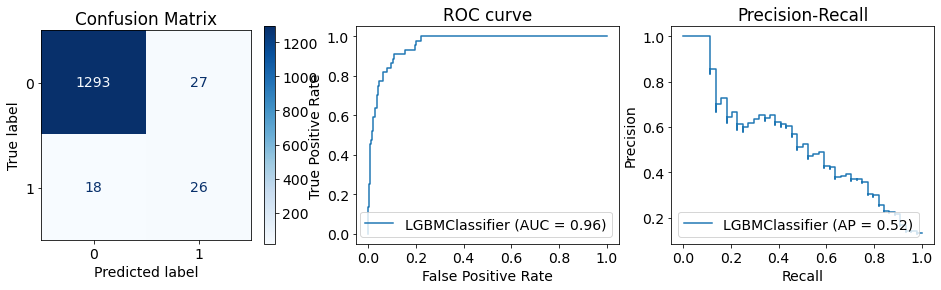

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.49      0.59      0.54        44

    accuracy                           0.97      1364
   macro avg       0.74      0.79      0.76      1364
weighted avg       0.97      0.97      0.97      1364



In [47]:
lgbm = LGBMClassifier(**params)
smote(lgbm, 'LGBM smote')

## XGBoost

mean CV f1: 0.3580813178482754


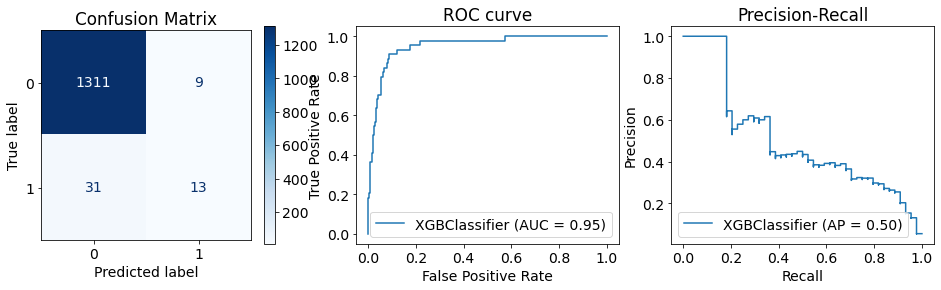

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.59      0.30      0.39        44

    accuracy                           0.97      1364
   macro avg       0.78      0.64      0.69      1364
weighted avg       0.96      0.97      0.97      1364

mean CV f1: 0.9857745573807968


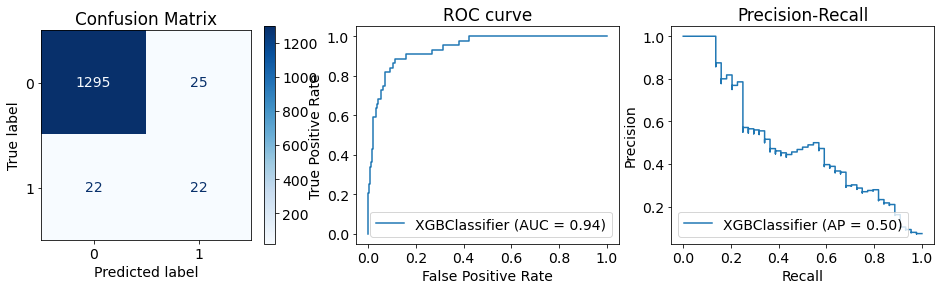

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.47      0.50      0.48        44

    accuracy                           0.97      1364
   macro avg       0.73      0.74      0.73      1364
weighted avg       0.97      0.97      0.97      1364



In [80]:
xgb = XGBClassifier()
test(xgb)
smote(xgb)

In [81]:
def objective(trial):
    
    param = {'booster':trial.suggest_categorical('booster', ['gbtree', 'dart']),
             'eta':trial.suggest_float('eta', 0, 1),
             'gamma':trial.suggest_float('gamma', 0, 100),
             'max_depth':trial.suggest_int('max_depth', 4, 30),
             'min_child_weight':trial.suggest_float('min_child_weight', 1, 50),
             'max_delta_step':trial.suggest_float('max_delta_step', 0, 10),
             'lambda':trial.suggest_float('lambda', 1e-6, 50),
             'alpha':trial.suggest_float('alpha', 0, 50),
             'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 50)
            }
        
    #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "f1")
    model = XGBClassifier(**param, subsample=0.5)
    
    model.fit(X_train, y_train)
    f1=cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
    
    

[I 2021-07-23 22:26:50,889] A new study created in memory with name: no-name-e22bc5e2-6896-4271-9844-59776a3b3425
[I 2021-07-23 22:26:56,138] Trial 0 finished with value: 0.3273940570208341 and parameters: {'booster': 'dart', 'eta': 0.34394271145150945, 'gamma': 74.01164171336802, 'max_depth': 8, 'min_child_weight': 36.300198280225004, 'max_delta_step': 7.337907984160267, 'lambda': 6.836674652448409, 'alpha': 19.36506942095475, 'scale_pos_weight': 41}. Best is trial 0 with value: 0.3273940570208341.
[I 2021-07-23 22:27:00,214] Trial 1 finished with value: 0.4526120907209217 and parameters: {'booster': 'dart', 'eta': 0.12594662624389164, 'gamma': 38.58244506911582, 'max_depth': 12, 'min_child_weight': 19.836293021060726, 'max_delta_step': 2.4892697384473195, 'lambda': 13.46497207444316, 'alpha': 48.85048572654861, 'scale_pos_weight': 10}. Best is trial 1 with value: 0.4526120907209217.
[I 2021-07-23 22:27:03,669] Trial 2 finished with value: 0.30377593445544004 and parameters: {'booster

[I 2021-07-23 22:28:13,314] Trial 20 finished with value: 0.44166940072300875 and parameters: {'booster': 'dart', 'eta': 0.6017778052078201, 'gamma': 1.3929511450767436, 'max_depth': 26, 'min_child_weight': 34.55780384021034, 'max_delta_step': 6.35147439657605, 'lambda': 34.16190790360044, 'alpha': 0.171211238503993, 'scale_pos_weight': 2}. Best is trial 12 with value: 0.4617805148151149.
[I 2021-07-23 22:28:16,401] Trial 21 finished with value: 0.43565916263412585 and parameters: {'booster': 'dart', 'eta': 0.025252714576745272, 'gamma': 98.50541009209105, 'max_depth': 13, 'min_child_weight': 49.68191534746358, 'max_delta_step': 4.174123578990378, 'lambda': 27.45253712453131, 'alpha': 26.87100930892029, 'scale_pos_weight': 10}. Best is trial 12 with value: 0.4617805148151149.
[I 2021-07-23 22:28:19,708] Trial 22 finished with value: 0.42639559713254355 and parameters: {'booster': 'dart', 'eta': 0.0033512272254291875, 'gamma': 92.0057216038683, 'max_depth': 11, 'min_child_weight': 45.72

[I 2021-07-23 22:29:25,535] Trial 41 finished with value: 0.4428175212962044 and parameters: {'booster': 'dart', 'eta': 0.16457761403195273, 'gamma': 49.971304847831064, 'max_depth': 22, 'min_child_weight': 27.873300295363624, 'max_delta_step': 0.5336918729711962, 'lambda': 5.215369301531247, 'alpha': 29.680856883678352, 'scale_pos_weight': 8}. Best is trial 40 with value: 0.47079023372159046.
[I 2021-07-23 22:29:28,184] Trial 42 finished with value: 0.04129554655870445 and parameters: {'booster': 'dart', 'eta': 0.13351305041823797, 'gamma': 57.28677796047384, 'max_depth': 25, 'min_child_weight': 32.02140257655251, 'max_delta_step': 1.1069521369542463, 'lambda': 3.3971218642941956, 'alpha': 31.786085143801834, 'scale_pos_weight': 3}. Best is trial 40 with value: 0.47079023372159046.
[I 2021-07-23 22:29:32,509] Trial 43 finished with value: 0.3936241734333779 and parameters: {'booster': 'dart', 'eta': 0.05032246391321753, 'gamma': 43.51089204309839, 'max_depth': 19, 'min_child_weight': 

[I 2021-07-23 22:30:43,170] Trial 62 finished with value: 0.4748320583978824 and parameters: {'booster': 'dart', 'eta': 0.14955780209877356, 'gamma': 41.21483755272841, 'max_depth': 12, 'min_child_weight': 35.63382361122817, 'max_delta_step': 3.297222442456813, 'lambda': 46.665891019882444, 'alpha': 13.621007888993077, 'scale_pos_weight': 6}. Best is trial 52 with value: 0.47755359276447373.
[I 2021-07-23 22:30:46,353] Trial 63 finished with value: 0.4338447034644134 and parameters: {'booster': 'dart', 'eta': 0.15299874857115264, 'gamma': 41.243263374513575, 'max_depth': 13, 'min_child_weight': 35.148655478375964, 'max_delta_step': 2.533392155128496, 'lambda': 42.5816725844628, 'alpha': 13.813235056497302, 'scale_pos_weight': 10}. Best is trial 52 with value: 0.47755359276447373.
[I 2021-07-23 22:30:49,180] Trial 64 finished with value: 0.45278922619693435 and parameters: {'booster': 'dart', 'eta': 0.23293510055241767, 'gamma': 36.14598264005521, 'max_depth': 11, 'min_child_weight': 39

[I 2021-07-23 22:31:51,729] Trial 83 finished with value: 0.4607570627256591 and parameters: {'booster': 'dart', 'eta': 0.03320382494581979, 'gamma': 17.405903712876214, 'max_depth': 22, 'min_child_weight': 20.04160485638127, 'max_delta_step': 3.1334651852687676, 'lambda': 49.5729893374668, 'alpha': 21.593429057677213, 'scale_pos_weight': 5}. Best is trial 71 with value: 0.4893389541251688.
[I 2021-07-23 22:31:55,326] Trial 84 finished with value: 0.43328258065647274 and parameters: {'booster': 'dart', 'eta': 0.17309239902682555, 'gamma': 10.225781832965351, 'max_depth': 24, 'min_child_weight': 27.842675086570253, 'max_delta_step': 5.19196376472525, 'lambda': 43.7251967413262, 'alpha': 23.891982535760516, 'scale_pos_weight': 10}. Best is trial 71 with value: 0.4893389541251688.
[I 2021-07-23 22:31:59,042] Trial 85 finished with value: 0.4681487573101918 and parameters: {'booster': 'dart', 'eta': 0.06881695477655375, 'gamma': 3.5770468718472346, 'max_depth': 17, 'min_child_weight': 25.5

In [50]:
params ={'booster': 'dart', 
         'eta': 0.11231022431214246, 
         'gamma': 31.81770790896552, 
         'max_depth': 16, 
         'min_child_weight': 29.885804973251073, 
         'max_delta_step': 3.500435319012715, 
         'lambda': 49.68608561326101, 
         'alpha': 24.241157360028758, 
         'scale_pos_weight': 6}

mean CV f1: 0.4482077743378053


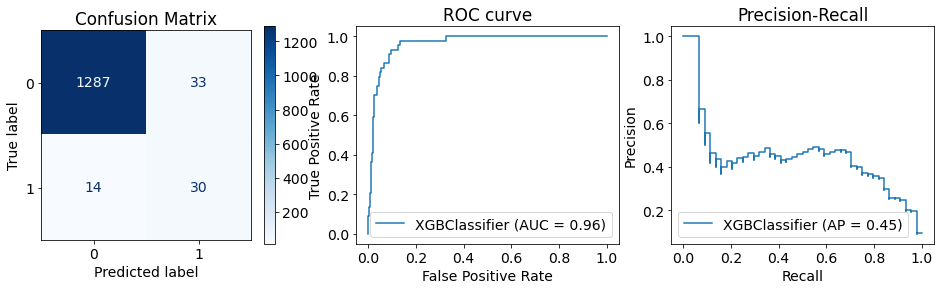

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.48      0.68      0.56        44

    accuracy                           0.97      1364
   macro avg       0.73      0.83      0.77      1364
weighted avg       0.97      0.97      0.97      1364



In [51]:
xgb = XGBClassifier(**params)
test(xgb, 'XGBoost')

In [58]:
def objective(trial):
    
    param = {'booster':trial.suggest_categorical('booster', ['gbtree', 'dart']),
             'eta':trial.suggest_float('eta', 0, 1),
             'gamma':trial.suggest_float('gamma', 0, 50),
             'max_depth':trial.suggest_int('max_depth', 4, 30),
             'min_child_weight':trial.suggest_float('min_child_weight', 1, 50),
             'max_delta_step':trial.suggest_float('max_delta_step', 0, 10),
             'lambda':trial.suggest_float('lambda', 0, 50),
             'alpha':trial.suggest_float('alpha', 0, 50),
             'scale_pos_weight':trial.suggest_int('scale_pos_weight', 1, 50)
            }
    
    #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "f1")
    model = XGBClassifier(**param)
                           
    model.fit(X_train_smote, y_train_smote)
    f1=cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
    

[I 2021-07-24 16:57:47,342] A new study created in memory with name: no-name-052870e7-3f2f-45f3-b7cf-2235a60c7d5b
[I 2021-07-24 16:57:52,166] Trial 0 finished with value: 0.30522088353413657 and parameters: {'booster': 'dart', 'eta': 0.099121543751298, 'gamma': 3.3183919143607907, 'max_depth': 23, 'min_child_weight': 13.192630838900955, 'max_delta_step': 6.363946867058785, 'lambda': 23.309536917318674, 'alpha': 36.7530556478023, 'scale_pos_weight': 48}. Best is trial 0 with value: 0.30522088353413657.
[I 2021-07-24 16:57:54,224] Trial 1 finished with value: 0.2797202797202797 and parameters: {'booster': 'dart', 'eta': 0.047969264445532844, 'gamma': 14.261788737571235, 'max_depth': 4, 'min_child_weight': 42.714312508855826, 'max_delta_step': 6.314064371570591, 'lambda': 4.386730299703068, 'alpha': 0.6293648103730065, 'scale_pos_weight': 7}. Best is trial 0 with value: 0.30522088353413657.
[I 2021-07-24 16:57:57,765] Trial 2 finished with value: 0.2939068100358423 and parameters: {'boost

[I 2021-07-24 16:58:50,853] Trial 20 finished with value: 0.3838383838383838 and parameters: {'booster': 'gbtree', 'eta': 0.63304489672781, 'gamma': 14.361065769226435, 'max_depth': 25, 'min_child_weight': 29.000605677718656, 'max_delta_step': 7.4706915836012335, 'lambda': 37.39523843357867, 'alpha': 2.3053220130550542, 'scale_pos_weight': 6}. Best is trial 17 with value: 0.4320987654320987.
[I 2021-07-24 16:58:52,808] Trial 21 finished with value: 0.46153846153846156 and parameters: {'booster': 'gbtree', 'eta': 0.8852793707000145, 'gamma': 6.160297327998942, 'max_depth': 21, 'min_child_weight': 32.2201408681754, 'max_delta_step': 5.6692409219642075, 'lambda': 28.568836388653683, 'alpha': 33.59477202786598, 'scale_pos_weight': 1}. Best is trial 21 with value: 0.46153846153846156.
[I 2021-07-24 16:58:54,437] Trial 22 finished with value: 0.4189189189189189 and parameters: {'booster': 'gbtree', 'eta': 0.8223692742747853, 'gamma': 5.506699642238655, 'max_depth': 22, 'min_child_weight': 33

[I 2021-07-24 16:59:29,227] Trial 41 finished with value: 0.3902439024390244 and parameters: {'booster': 'gbtree', 'eta': 0.6233739013489912, 'gamma': 2.3215267125482937, 'max_depth': 21, 'min_child_weight': 27.722048223526937, 'max_delta_step': 9.544518781537194, 'lambda': 38.50976771336061, 'alpha': 18.007132941723228, 'scale_pos_weight': 9}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 16:59:31,092] Trial 42 finished with value: 0.44295302013422816 and parameters: {'booster': 'gbtree', 'eta': 0.8572292801306545, 'gamma': 3.241388406221133, 'max_depth': 20, 'min_child_weight': 25.366280596077466, 'max_delta_step': 9.977777159065589, 'lambda': 34.65729023383953, 'alpha': 14.207454532205286, 'scale_pos_weight': 3}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 16:59:33,682] Trial 43 finished with value: 0.39779005524861877 and parameters: {'booster': 'gbtree', 'eta': 0.9278697135606142, 'gamma': 13.239149627600687, 'max_depth': 18, 'min_child_weight':

[I 2021-07-24 17:00:12,062] Trial 62 finished with value: 0.4696969696969697 and parameters: {'booster': 'gbtree', 'eta': 0.9981208670673078, 'gamma': 2.04302774657752, 'max_depth': 18, 'min_child_weight': 17.400291789460177, 'max_delta_step': 9.978495200644831, 'lambda': 42.47254891205573, 'alpha': 21.97646040759507, 'scale_pos_weight': 1}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 17:00:14,587] Trial 63 finished with value: 0.4166666666666667 and parameters: {'booster': 'gbtree', 'eta': 0.9453296240028289, 'gamma': 2.0392776482947905, 'max_depth': 18, 'min_child_weight': 8.480047815919825, 'max_delta_step': 9.362191699819633, 'lambda': 42.312554247151354, 'alpha': 21.67057513663985, 'scale_pos_weight': 4}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 17:00:17,015] Trial 64 finished with value: 0.43283582089552236 and parameters: {'booster': 'gbtree', 'eta': 0.9954607436289888, 'gamma': 1.6995551219683422, 'max_depth': 16, 'min_child_weight': 13.

[I 2021-07-24 17:01:06,640] Trial 83 finished with value: 0.36585365853658536 and parameters: {'booster': 'gbtree', 'eta': 0.42345256234448053, 'gamma': 8.00802844691511, 'max_depth': 19, 'min_child_weight': 22.939568131952576, 'max_delta_step': 9.64096371319655, 'lambda': 32.19935115386433, 'alpha': 0.7454901793432973, 'scale_pos_weight': 10}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 17:01:09,097] Trial 84 finished with value: 0.41212121212121217 and parameters: {'booster': 'gbtree', 'eta': 0.46467642600957926, 'gamma': 5.491227354883003, 'max_depth': 22, 'min_child_weight': 18.67831985431552, 'max_delta_step': 8.976181978065533, 'lambda': 36.54960457035181, 'alpha': 3.5737740214578375, 'scale_pos_weight': 9}. Best is trial 31 with value: 0.4714285714285714.
[I 2021-07-24 17:01:12,277] Trial 85 finished with value: 0.38372093023255816 and parameters: {'booster': 'gbtree', 'eta': 0.34943558432423955, 'gamma': 9.554356679961806, 'max_depth': 18, 'min_child_weight':

In [51]:
params ={'booster': 'gbtree', 
         'eta': 0.4844582082502639, 
         'gamma': 1.4458640017126791, 
         'max_depth': 21, 
         'min_child_weight': 19.95646048296095, 
         'max_delta_step': 9.116131459014143, 
         'lambda': 33.68817037461091, 
         'alpha': 0.4278627789424059, 
         'scale_pos_weight': 11}

mean CV f1: 0.9750453365332624


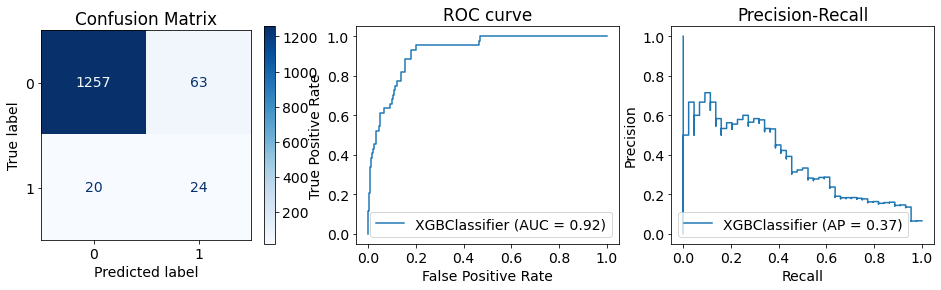

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1320
           1       0.28      0.55      0.37        44

    accuracy                           0.94      1364
   macro avg       0.63      0.75      0.67      1364
weighted avg       0.96      0.94      0.95      1364



In [52]:
xgb = XGBClassifier(**params)
smote(xgb, 'XGB smote')

## ExtraTrees

mean CV f1: 0.16666666666666666


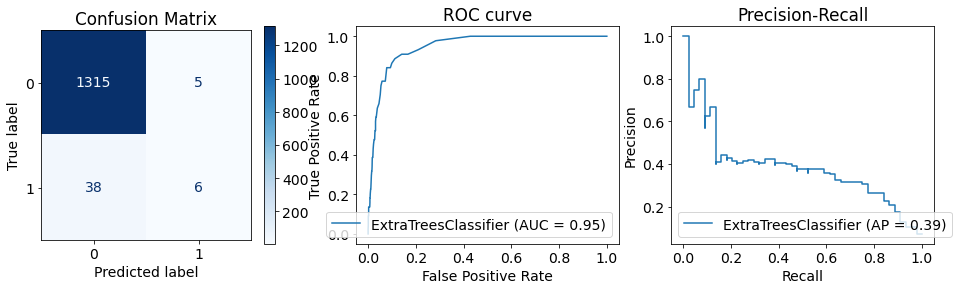

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.55      0.14      0.22        44

    accuracy                           0.97      1364
   macro avg       0.76      0.57      0.60      1364
weighted avg       0.96      0.97      0.96      1364

mean CV f1: 0.9799777096664721


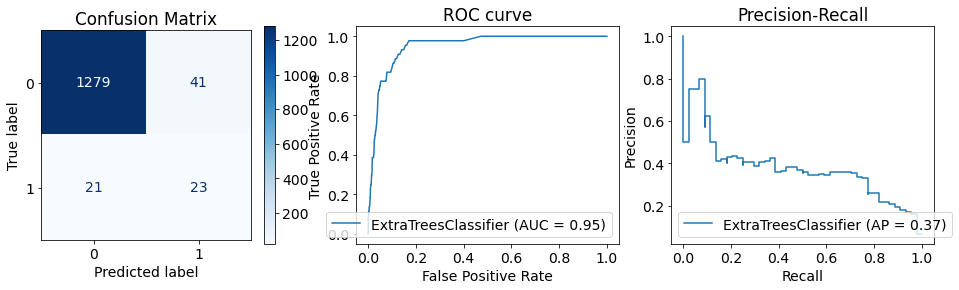

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.36      0.52      0.43        44

    accuracy                           0.95      1364
   macro avg       0.67      0.75      0.70      1364
weighted avg       0.96      0.95      0.96      1364



In [91]:
etc = ExtraTreesClassifier()
test(etc)
smote(etc)

In [65]:
classweights=['balanced', 'balanced_subsample']
for i in np.arange(1, 50):
        classweights.append({0:1, 1:i})

def objective(trial):
    
    param = {'n_estimators':trial.suggest_int('n_estimators', 50, 300),
             'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy']),
             'max_depth':trial.suggest_int('max_depth', 3, 40),
             'min_samples_split':trial.suggest_int('min_samples_split', 2, 100),
             'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 100),
             'max_features':trial.suggest_int('max_features', 5, 93),
             'class_weight':trial.suggest_categorical('class_weight', classweights)
            }
        

    model = ExtraTreesClassifier(**param)
                           
    model.fit(X_train, y_train)
    f1=cross_val_score(model, X_train, y_train, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=3, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-07-24 17:27:26,778] A new study created in memory with name: no-name-20335847-ef33-472f-99c2-a98a4da26bf9
[I 2021-07-24 17:27:29,170] Trial 0 finished with value: 0.3999999999999999 and parameters: {'n_estimators': 285, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 83, 'min_samples_leaf': 67, 'max_features': 71, 'class_weight': {0: 1, 1: 14}}. Best is trial 0 with value: 0.3999999999999999.
[I 2021-07-24 17:27:29,563] Trial 1 finished with value: 0.392156862745098 and parameters: {'n_estimators': 286, 'criterion': 'entropy', 'max_depth': 23, 'min_samples_split': 60, 'min_samples_leaf': 58, 'max_features': 5, 'class_weight': {0: 1, 1: 26}}. Best is trial 0 with value: 0.3999999999999999.
[I 2021-07-24 17:27:30,356] Trial 2 finished with value: 0.4585987261146497 and parameters: {'n_estimators': 131, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 46, 'max_features': 49, 'class_weight': {0: 1, 1: 11}}. Best is trial 2 with value: 0

[I 2021-07-24 17:27:58,489] Trial 26 finished with value: 0.3502304147465438 and parameters: {'n_estimators': 184, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 42, 'min_samples_leaf': 9, 'max_features': 25, 'class_weight': {0: 1, 1: 42}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:27:59,360] Trial 27 finished with value: 0.3220338983050848 and parameters: {'n_estimators': 145, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 44, 'class_weight': {0: 1, 1: 39}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:27:59,972] Trial 28 finished with value: 0.3857868020304568 and parameters: {'n_estimators': 103, 'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': 32, 'class_weight': {0: 1, 1: 45}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:28:02,292] Trial 29 finished with value: 0.3448275862068965 and parameters

[I 2021-07-24 17:28:29,752] Trial 52 finished with value: 0.48 and parameters: {'n_estimators': 210, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 53, 'min_samples_leaf': 11, 'max_features': 46, 'class_weight': {0: 1, 1: 13}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:28:30,901] Trial 53 finished with value: 0.33628318584070793 and parameters: {'n_estimators': 199, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 69, 'min_samples_leaf': 6, 'max_features': 38, 'class_weight': {0: 1, 1: 40}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:28:32,112] Trial 54 finished with value: 0.4999999999999999 and parameters: {'n_estimators': 210, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 60, 'min_samples_leaf': 11, 'max_features': 34, 'class_weight': {0: 1, 1: 10}}. Best is trial 8 with value: 0.5137614678899082.
[I 2021-07-24 17:28:33,256] Trial 55 finished with value: 0.46478873239436613 and parameters: {'n_es

[I 2021-07-24 17:28:53,140] Trial 78 finished with value: 0.4680851063829786 and parameters: {'n_estimators': 84, 'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 92, 'min_samples_leaf': 12, 'max_features': 54, 'class_weight': {0: 1, 1: 9}}. Best is trial 71 with value: 0.5357142857142857.
[I 2021-07-24 17:28:53,859] Trial 79 finished with value: 0.4827586206896552 and parameters: {'n_estimators': 67, 'criterion': 'gini', 'max_depth': 26, 'min_samples_split': 73, 'min_samples_leaf': 38, 'max_features': 59, 'class_weight': {0: 1, 1: 6}}. Best is trial 71 with value: 0.5357142857142857.
[I 2021-07-24 17:28:55,048] Trial 80 finished with value: 0.3225806451612903 and parameters: {'n_estimators': 111, 'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 98, 'min_samples_leaf': 25, 'max_features': 72, 'class_weight': {0: 1, 1: 47}}. Best is trial 71 with value: 0.5357142857142857.
[I 2021-07-24 17:28:56,658] Trial 81 finished with value: 0.41884816753926707 and parameters: {

In [69]:
params ={'n_estimators': 69, 
         'criterion': 'gini', 
         'max_depth': 25, 
         'min_samples_split': 79, 
         'min_samples_leaf': 10, 
         'max_features': 56, 
         'class_weight': {0: 1, 1: 6}}

mean CV f1: 0.42517205950428155


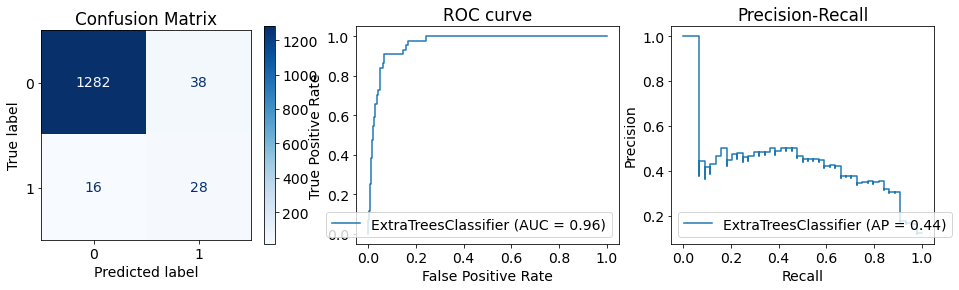

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.42      0.64      0.51        44

    accuracy                           0.96      1364
   macro avg       0.71      0.80      0.74      1364
weighted avg       0.97      0.96      0.96      1364



In [70]:
etc = ExtraTreesClassifier(**params)
test(etc, 'Extra Trees')

In [98]:
classweights=['balanced', 'balanced_subsample']
for i in np.arange(1, 50):
        classweights.append({0:1, 1:i})

def objective(trial):
    
    param = {'n_estimators':trial.suggest_int('n_estimators', 50, 300),
             'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy']),
             'max_depth':trial.suggest_int('max_depth', 3, 40),
             'min_samples_split':trial.suggest_int('min_samples_split', 2, 100),
             'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 100),
             'max_features':trial.suggest_int('max_features', 5, 93),
             'class_weight':trial.suggest_categorical('class_weight', classweights)
            }
        

    model = ExtraTreesClassifier(**param)
                           
    model.fit(X_train_smote, y_train_smote)
    f1=cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, scoring='f1', 
                       cv=StratifiedKFold(n_splits=5, shuffle=True)).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
    

[I 2021-07-23 23:22:10,197] A new study created in memory with name: no-name-23369bb0-9427-4f62-8556-40afc31ae82c
[I 2021-07-23 23:22:18,802] Trial 0 finished with value: 0.86023746827018 and parameters: {'n_estimators': 202, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 91, 'min_samples_leaf': 92, 'max_features': 80, 'class_weight': {0: 1, 1: 7}}. Best is trial 0 with value: 0.86023746827018.
[I 2021-07-23 23:22:22,293] Trial 1 finished with value: 0.8183066964309693 and parameters: {'n_estimators': 93, 'criterion': 'entropy', 'max_depth': 33, 'min_samples_split': 35, 'min_samples_leaf': 96, 'max_features': 43, 'class_weight': {0: 1, 1: 35}}. Best is trial 0 with value: 0.86023746827018.
[I 2021-07-23 23:22:27,934] Trial 2 finished with value: 0.8599379629395904 and parameters: {'n_estimators': 75, 'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 47, 'max_features': 74, 'class_weight': {0: 1, 1: 36}}. Best is trial 0 with value: 0.86023

[I 2021-07-23 23:25:32,704] Trial 26 finished with value: 0.9106563265840514 and parameters: {'n_estimators': 55, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 28, 'min_samples_leaf': 9, 'max_features': 72, 'class_weight': {0: 1, 1: 44}}. Best is trial 22 with value: 0.9473226816477138.
[I 2021-07-23 23:25:36,027] Trial 27 finished with value: 0.9328231978269675 and parameters: {'n_estimators': 73, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 39, 'min_samples_leaf': 16, 'max_features': 35, 'class_weight': {0: 1, 1: 4}}. Best is trial 22 with value: 0.9473226816477138.
[I 2021-07-23 23:25:39,358] Trial 28 finished with value: 0.9361913571687339 and parameters: {'n_estimators': 76, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 34, 'class_weight': {0: 1, 1: 4}}. Best is trial 22 with value: 0.9473226816477138.
[I 2021-07-23 23:25:45,818] Trial 29 finished with value: 0.9055164934000794 and paramete

[I 2021-07-23 23:27:39,688] Trial 52 finished with value: 0.9483762857107247 and parameters: {'n_estimators': 157, 'criterion': 'gini', 'max_depth': 37, 'min_samples_split': 29, 'min_samples_leaf': 1, 'max_features': 30, 'class_weight': {0: 1, 1: 39}}. Best is trial 44 with value: 0.9540810169323836.
[I 2021-07-23 23:27:51,350] Trial 53 finished with value: 0.9483574610880323 and parameters: {'n_estimators': 179, 'criterion': 'gini', 'max_depth': 34, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': 30, 'class_weight': {0: 1, 1: 33}}. Best is trial 44 with value: 0.9540810169323836.
[I 2021-07-23 23:27:57,771] Trial 54 finished with value: 0.9153305383904801 and parameters: {'n_estimators': 146, 'criterion': 'gini', 'max_depth': 34, 'min_samples_split': 22, 'min_samples_leaf': 12, 'max_features': 32, 'class_weight': {0: 1, 1: 25}}. Best is trial 44 with value: 0.9540810169323836.
[I 2021-07-23 23:28:01,481] Trial 55 finished with value: 0.8237614471276228 and parameters: 

[I 2021-07-23 23:30:06,681] Trial 78 finished with value: 0.9375074273018577 and parameters: {'n_estimators': 247, 'criterion': 'gini', 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 14, 'class_weight': 'balanced_subsample'}. Best is trial 69 with value: 0.9817258411390322.
[I 2021-07-23 23:30:12,557] Trial 79 finished with value: 0.9551115548587144 and parameters: {'n_estimators': 269, 'criterion': 'gini', 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 11, 'class_weight': 'balanced_subsample'}. Best is trial 69 with value: 0.9817258411390322.
[I 2021-07-23 23:30:20,258] Trial 80 finished with value: 0.9483013253969995 and parameters: {'n_estimators': 293, 'criterion': 'gini', 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 17, 'class_weight': 'balanced_subsample'}. Best is trial 69 with value: 0.9817258411390322.
[I 2021-07-23 23:30:26,256] Trial 81 finished with value: 0.9535017705907

In [63]:
params ={'n_estimators': 253, 
         'criterion': 'gini', 
         'max_depth': 38, 
         'min_samples_split': 6, 
         'min_samples_leaf': 1, 
         'max_features': 9, 
         'class_weight': 'balanced_subsample'}

mean CV f1: 0.9785596231829202


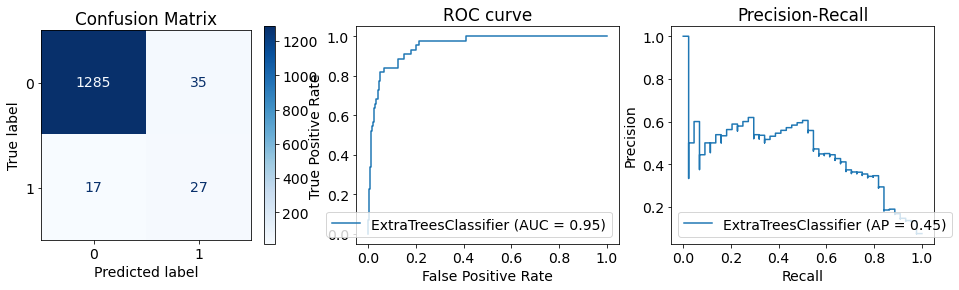

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.44      0.61      0.51        44

    accuracy                           0.96      1364
   macro avg       0.71      0.79      0.74      1364
weighted avg       0.97      0.96      0.96      1364



In [64]:
etc = ExtraTreesClassifier(**params)
smote(etc, 'ET smote')

## Results summary

In [117]:
results.reset_index()

,index,FN,FP,TP,TN,FPR,TPR,ACC,PREC,F1,F1 micro,F1 macro,F1 weighted
0,Random Forest,26.00,22.00,18.00,1298.00,0.02,0.41,0.96,0.45,0.43,0.96,0.71,0.96
1,RF smote SMOTE,17.00,33.00,27.00,1287.00,0.03,0.61,0.96,0.45,0.52,0.96,0.75,0.97
2,GradientBoost,28.00,23.00,16.00,1297.00,0.02,0.36,0.96,0.41,0.39,0.96,0.68,0.96
3,GB smote SMOTE,21.00,26.00,23.00,1294.00,0.02,0.52,0.97,0.47,0.49,0.97,0.74,0.97
4,LGBM,18.00,39.00,26.00,1281.00,0.03,0.59,0.96,0.40,0.48,0.96,0.73,0.96
5,LGBM smote SMOTE,18.00,27.00,26.00,1293.00,0.02,0.59,0.97,0.49,0.54,0.97,0.76,0.97
6,XGBoost,14.00,33.00,30.00,1287.00,0.03,0.68,0.97,0.48,0.56,0.97,0.77,0.97
7,XGB smote SMOTE,14.00,52.00,30.00,1268.00,0.04,0.68,0.95,0.37,0.48,0.95,0.73,0.96
8,Extra Trees,16.00,38.00,28.00,1282.00,0.03,0.64,0.96,0.42,0.51,0.96,0.74,0.96
9,ET smote SMOTE,17.00,35.00,27.00,1285.00,0.03,0.61,0.96,0.44,0.51,0.96,0.74,0.96


## Stacking

In [10]:
from mlxtend.classifier import StackingCVClassifier

In [13]:
m1 = RandomForestClassifier(**{'max_depth': 10, 
        'n_estimators': 191, 
        'criterion': 'entropy', 
        'min_samples_split': 51, 
        'min_samples_leaf': 8, 
        'max_features': 78, 
        'class_weight': {0: 1, 1: 7}})

m2 = GradientBoostingClassifier(**{'loss': 'exponential', 
         'n_estimators': 151, 
         'subsample': 0.05475007454483049, 
         'min_samples_split': 0.035007989410884614, 
         'min_samples_leaf': 0.004477768163814546, 
         'max_depth': 16, 
         'max_features': 18})

m3 = LGBMClassifier(**{'boosting_type': 'rf', 
          'num_leaves': 47, 
          'max_depth': 5, 
          'learning_rate': 0.07162554136330458, 
          'n_estimators': 192, 
          'subsample_for_bin': 166307, 
          'bagging_freq': 6, 
          'min_data_in_leaf': 14, 
          'lambda_l1': 0.1654260899402262, 
          'lambda_l2': 0.7263466248471901, 
          'bagging_fraction': 0.49106685394922966, 
          'feature_fraction': 0.6651939867004374, 
          'num_threads': 7, 
          'min_sum_hessian_in_leaf': 1})

m4 = XGBClassifier(**{'booster': 'dart', 
         'eta': 0.11231022431214246, 
         'gamma': 31.81770790896552, 
         'max_depth': 16, 
         'min_child_weight': 29.885804973251073, 
         'max_delta_step': 3.500435319012715, 
         'lambda': 49.68608561326101, 
         'alpha': 24.241157360028758, 
         'scale_pos_weight': 6})
     
m5 = ExtraTreesClassifier(**{'n_estimators': 69, 
         'criterion': 'gini', 
         'max_depth': 25, 
         'min_samples_split': 79, 
         'min_samples_leaf': 10, 
         'max_features': 56, 
         'class_weight': {0: 1, 1: 6}}) 

m6 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
                ('log', LogisticRegression(penalty='elasticnet',
                                           solver='saga',
                                           C=0.0015,
                                           l1_ratio=0.47777777777777775,
                                           class_weight={0:1, 1:9}))])

m7 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
               ('svc', SVC(C=0.1, class_weight={0: 1, 1:5}, gamma='scale',
                     kernel='linear'))])

m8 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
               ('nb', GaussianNB(var_smoothing=0.22727272727272727))])
              
m9 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),  
               ('lda', LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'))])
              
m10 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
                  ('qda', QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True))])
              
              

models = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]

stack = StackingCVClassifier(classifiers=models, 
                             meta_classifier = m4, 
                             use_features_in_secondary=True,
                             cv=kf,
                             store_train_meta_features = True
                             )                   

In [25]:
stack.fit(X_train, y_train)
score(stack, X_train, y_train)
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))

StackingCVClassifier(classifiers=[RandomForestClassifier(class_weight={0: 1,
                                                                       1: 7},
                                                         criterion='entropy',
                                                         max_depth=10,
                                                         max_features=78,
                                                         min_samples_leaf=8,
                                                         min_samples_split=51,
                                                         n_estimators=191),
                                  GradientBoostingClassifier(loss='exponential',
                                                             max_depth=16,
                                                             max_features=18,
                                                             min_samples_leaf=0.004477768163814546,
                                                        

mean CV f1: 0.4431672266179308
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.44      0.70      0.54        44

    accuracy                           0.96      1364
   macro avg       0.72      0.84      0.76      1364
weighted avg       0.97      0.96      0.97      1364



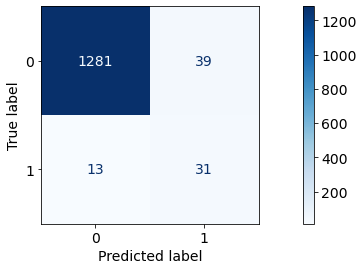

In [26]:
plot_confusion_matrix(stack, X_test, y_test,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues)
plt.show();

mean CV f1: 0.4642174773540382
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.37      0.52      0.43        44

    accuracy                           0.96      1364
   macro avg       0.68      0.75      0.71      1364
weighted avg       0.96      0.96      0.96      1364



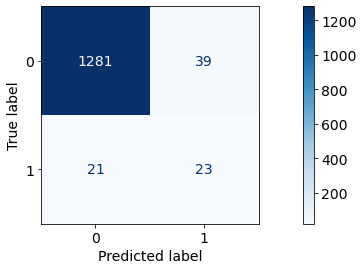

In [14]:
stack.fit(X_train, y_train)
score(stack, X_train, y_train)
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(stack, X_test, y_test,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues)
plt.show();

In [14]:
stack.fit(X_train_smote, y_train_smote)
score(stack, X_train_smote, y_train_smote)
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))

StackingCVClassifier(classifiers=[RandomForestClassifier(class_weight={0: 1,
                                                                       1: 7},
                                                         criterion='entropy',
                                                         max_depth=10,
                                                         max_features=78,
                                                         min_samples_leaf=8,
                                                         min_samples_split=51,
                                                         n_estimators=191),
                                  GradientBoostingClassifier(loss='exponential',
                                                             max_depth=16,
                                                             max_features=18,
                                                             min_samples_leaf=0.004477768163814546,
                                                        

mean CV f1: 0.9465918939571619
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1320
           1       0.25      0.82      0.39        44

    accuracy                           0.92      1364
   macro avg       0.62      0.87      0.67      1364
weighted avg       0.97      0.92      0.94      1364



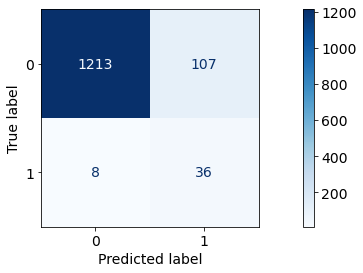

In [15]:
plot_confusion_matrix(stack, X_test, y_test,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues)
plt.show();

In [11]:
m1 = RandomForestClassifier(**{'max_depth': 19, 
                               'n_estimators': 187, 
                               'criterion': 'entropy', 
                               'min_samples_split': 2, 
                               'min_samples_leaf': 1, 
                               'max_features': 5, 
                               'class_weight': {0: 1, 1: 7}})

m2 = GradientBoostingClassifier(**{'loss': 'deviance', 
                                   'n_estimators': 500, 
                                   'subsample': 0.7483929023149966, 
                                   'min_samples_split': 0.004832374971046467, 
                                   'min_samples_leaf': 0.0037119139346152657, 
                                   'max_depth': 20, 
                                   'max_features': 18})

m3 = LGBMClassifier(**{'boosting_type': 'gbdt', 
                       'num_leaves': 22, 
                       'max_depth': 19, 
                       'learning_rate': 0.1768380635256963, 
                       'n_estimators': 126, 
                       'subsample_for_bin': 84471, 
                       'bagging_freq': 5, 
                       'min_data_in_leaf': 87, 
                       'lambda_l1': 1.7308700391559487e-07, 
                       'lambda_l2': 0.009991011111757766, 
                       'bagging_fraction': 0.9034437897761284, 
                       'feature_fraction': 0.9368900567606943, 
                       'num_threads': 7, 
                       'min_sum_hessian_in_leaf': 9, 
                       'scale_pos_weight': 1})

m4 = XGBClassifier(**{'booster': 'gbtree', 
                      'eta': 0.824957070971101, 
                      'gamma': 0.8464201159021294, 
                      'max_depth': 26, 
                      'min_child_weight': 34.82840042077465, 
                      'max_delta_step': 1.4296008766096004, 
                      'lambda': 30.94602191119681, 
                      'alpha': 3.7243806082787168, 
                      'scale_pos_weight': 9})

m5 = ExtraTreesClassifier(**{'n_estimators': 253, 
                             'criterion': 'gini', 
                             'max_depth': 38, 
                             'min_samples_split': 6, 
                             'min_samples_leaf': 1, 
                             'max_features': 9, 
                             'class_weight': 'balanced_subsample'})
m6 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
                ('log', LogisticRegression(penalty='elasticnet',
                                           solver='saga',
                                           C=0.0015,
                                           l1_ratio=0.47777777777777775,
                                           class_weight={0:1, 1:9}))])

m7 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
               ('svc', SVC(C=0.1, class_weight={0: 1, 1:5}, gamma='scale',
                     kernel='linear'))])

m8 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
               ('nb', GaussianNB(var_smoothing=0.22727272727272727))])
              
m9 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),  
               ('lda', LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr'))])
              
m10 = Pipeline([('minmax', MinMaxScaler()),
                ('scale', PowerTransformer()),
                  ('qda', QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariance=True))])
              

models = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]

stack = StackingCVClassifier(classifiers=models, 
                             meta_classifier = m4, 
                             use_features_in_secondary=True,
                             cv=kf,
                             store_train_meta_features = True
                             )

In [29]:
stack.fit(X_train_smote, y_train_smote)
score(stack, X_train_smote, y_train_smote)
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))

StackingCVClassifier(classifiers=[RandomForestClassifier(class_weight={0: 1,
                                                                       1: 7},
                                                         criterion='entropy',
                                                         max_depth=19,
                                                         max_features=5,
                                                         n_estimators=187),
                                  GradientBoostingClassifier(max_depth=20,
                                                             max_features=18,
                                                             min_samples_leaf=0.0037119139346152657,
                                                             min_samples_split=0.004832374971046467,
                                                             n_estimators=500,
                                                             subsample=0.7483929023149966),
                     

mean CV f1: 0.9904215106106052
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1320
           1       0.92      0.82      0.87        44

    accuracy                           0.99      1364
   macro avg       0.96      0.91      0.93      1364
weighted avg       0.99      0.99      0.99      1364



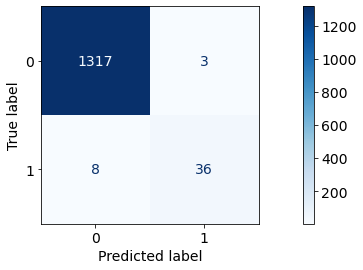

In [30]:
plot_confusion_matrix(stack, X_test, y_test,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues)
plt.show();

mean CV f1: 0.9914531322589997
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.58      0.32      0.41        44

    accuracy                           0.97      1364
   macro avg       0.78      0.66      0.70      1364
weighted avg       0.96      0.97      0.97      1364



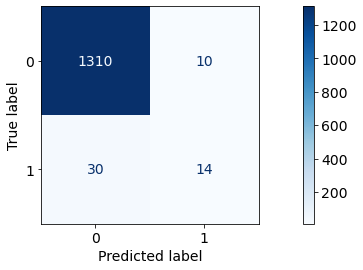

In [12]:
stack.fit(X_train_smote, y_train_smote)
score(stack, X_train_smote, y_train_smote)
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(stack, X_test, y_test,
                            display_labels = [0, 1],
                            cmap = plt.cm.Blues)
plt.show();